# DataCamp Certification Case Study

### Project Brief

Congratulations, you have just landed your first job as a data scientist at Snow Cone Games! Snow Cone Games are a digital retailer for video games. For your first assignment, you will be working with the product manager to find new ways to categorize games on their homepage. 

She has recently learned that only 23% of buyers search for games using the genre filter (e.g., action, sports, etc). 71% of buyers use advanced filters to find the types of games that appeal to them. She hopes that creative new categories based on different game attributes can help players find what they are looking for faster.

You have a dataset containing the Snow Cone Games’ library of over 40,000 video games. The product manager would like to see if you can group the data into categories that make sense. She has also told you that she wants to avoid more than five categories if possible, as any more would be difficult to fit into the platform homepage. 

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the product manager in a 10 minute presentation. The product manager has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/video_games.csv"`

## Initial data ingestion and inspection

In [1]:
# Import pandas
import pandas as pd

# Import data into pandas dataframe and inspect first few rows
games = pd.read_csv('data/video_games.csv')
games.head()

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
0,DOOM,"May 12, 2016",id Software,54.0,$19.99,92%,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,$29.99,49%,836608.0,True,True
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,$39.99,71%,7030.0,True,False
3,DayZ,"Dec 13, 2018",Bohemia Interactive,NaN,$44.99,61%,167115.0,True,False
4,EVE Online,"May 6, 2003",CCP,NaN,Free,74%,11481.0,True,False


With the initial import successful we can use both the info method to give a brief overview of the data. This allows us to anticipate any cleaning or reshaping the data may require.

In [2]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40833 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              40817 non-null  object 
 1   release_date      37654 non-null  object 
 2   developer         40490 non-null  object 
 3   achievements      12194 non-null  float64
 4   original_price    35522 non-null  object 
 5   percent_positive  17363 non-null  object 
 6   num_reviews       17363 non-null  float64
 7   multiplayer       40313 non-null  object 
 8   mature            40833 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 2.5+ MB


From the written brief and results of info there are some issues to fix before any exploratory data analysis (EDA) can begin.

### Data Types fixes
1. The release_date column would be better as a datetime object data type.
2. The original_price column would be better as a numeric data type.
3. The percent_positive column would be better as a numeric data type.
4. The multiplayer column would be better as a boolean data type.

Once the data types are corrected work can begin on the missing values.

###  1. The 'release_date' column

In [3]:
# Check formats of release date by checking the unique values of the length of the value.
# From the head of the games dataframe we would assume either 11 or 12 characters or 4 for the NULL value.

# Fill NULL values to allow for use of len()
games['release_date'].fillna("NULL", inplace = True)

# List comprehension of lengths 
list_of_lengths = [len(x) for x in games['release_date']]

# Change to set and print
set_of_lengths= set(list_of_lengths)
print(set_of_lengths)

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 42, 46, 50, 67, 89, 221}


What has only 2 characters or over 50 characters for a date?

In [4]:
# Get a list of all the values of 'release_date' sorted by length
sorted_list = sorted(games['release_date'].tolist(), key=len)

# Print the head and tail of sorted_list
print(sorted_list[0:5])
print(sorted_list[-5:-1])

['秋季', 'TBA', 'TBD', 'TBA', 'TBA']
['At the moment in development, add to wishlist!', 'When what lurks beneath the surface becomes known.', 'O jogo está em desenvolvimento e pode ser lançado até o fim de 2019', 'Official Release Coming Soon! - Twitch Subscriber Builds available at twitch.tv/wheeze202']


Snow Cone Games does not have specified format for entering release dates on their marketplace with different langauges and string advertisements being in the dataset. The data from this column cannot be used to create categories for filter.

The values 'TBD' and 'TBA' (abbreviations for "To Be Decided/Announced") also indicate there are games that are listed on the site but haven't been released yet.

Tighter controls for release date data entry to allow filtering based on release date is recommended.

### 2. The 'original_price' column

Games that don't have an original_price or a release_date are games that haven't been released so haven't been giving a price. These can be discounted from the modelling.

In [5]:
# Drop rows that have a Na original_price and a 'NULL' release_date
games = games.drop(games.index[games["original_price"].isna() & (games['release_date']=='NULL')])

# Reset index inplace
games.reset_index(drop=True, inplace=True)

All other null values for price can be assumed to be "Free" as no price info was given.

In [6]:
# Fill na values with 'Free'
games["original_price"].fillna('Free', inplace=True)

Find all the prices that have "free" or "Free" in the string and change to "0". This would include games that include "Free to play" or "Start playing for free!" as their original_place value.

In [7]:
# Change all string values to lower case
games["original_price"] = games["original_price"].str.lower()

# Create an empty list to take index numbers
slice_for_free = []

# Append all index values that are not null and contain 'free'
slice_for_free.append(games[pd.notnull(games["original_price"]) & games["original_price"].str.contains(r'free')]['original_price'].index)

# Replace all index values with '0'
for i in slice_for_free:
    games["original_price"][i] = '0'

Remove dollar symbols.

In [8]:
# Replace '$' symbol with nothing
games['original_price'] = games['original_price'].str.replace('$', '')

Check to see if there are any non-numeric string values remaining in "original_price" column by looking at the first element of the original_price column value.

In [9]:
# Create a list of numbers to be checked against string contents
numbers = ["0","1","2","3","4","5","6","7","8","9"]

# Find the rows that DO NOT have numbers as their first element
games[~games['original_price'].str.get(0).isin(numbers)].head()

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
50,Middle-earth™: Shadow of War™,"Oct 9, 2017",Monolith Productions,72.0,demo middle-earth™: shadow of war™,77%,16973.0,False,True
189,FINAL FANTASY XV WINDOWS EDITION,"Mar 6, 2018",Square Enix,97.0,final fantasy xv windows edition playable demo,77%,12902.0,True,False
214,UNO,"Dec 8, 2016",Ubisoft Entertainment,NaN,uno,57%,4174.0,True,False
532,Thea 2: The Shattering,"May 13, 2019","MuHa Games,Eerie Forest Studio",26.0,demo,76%,416.0,False,True
537,CrossCode,"Sep 20, 2018",Radical Fish Games,86.0,crosscode demo,94%,5680.0,False,False


With references to game demos which would presumably be free in place of the full game price, it's difficult to impute or infer any value for original_price given the range of potential values. These rows will be dropped.

In [10]:
# Create a list of index values of rows that DO NOT have numbers as their first element
index_drop = [games[~games['original_price'].str.get(0).isin(numbers)].index]

# Loop through index list and drop values 
for i in index_drop:
	games.drop(games.index[i], inplace=True)
    
# Reset index inplace
games.reset_index(drop=True, inplace=True)

Check the last elements of "original price" for non-numeric string values, incase "3d" is used at the beginning of a value for example.

In [11]:
# Find the values that DO NOT have numbers as their last element
games[~games['original_price'].str.get(-1).isin(numbers)].head()

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
10563,3DCoat Modding Tool,"Feb 27, 2018",Pilgway,NaN,3dcoat modding tool demo,NaN,NaN,False,False


We can remove this single value from index 10563 as again we cannot infer or impute any numeric value.

In [12]:
# Drop single value based on index
games.drop(index=10563, inplace=True)

# Reset index inplace
games.reset_index(drop=True, inplace=True)

The column dtype can now be changed to float.

In [13]:
# Cast column as type 'float'
games['original_price'] = games['original_price'].astype(float)

### 3. The 'percent_positive' column

Removing the '%' symbol will allow the 'percent_positive' column to be set to dtype float.

In [14]:
# Remove '%' symbol
games['percent_positive'] = games['percent_positive'].str.replace('%', '')

# Cast column as type 'float'
games['percent_positive'] = games['percent_positive'].astype(float)

# Divide column values by 100 as it describes a percentage
games['percent_positive'] = games['percent_positive'].div(100)

In [15]:
games.describe()

,achievements,original_price,percent_positive,num_reviews
count,12053.000000,38090.000000,17214.000000,17214.000000
mean,77.809508,49.418654,0.746996,1305.389509
std,451.072069,5012.672513,0.185702,11593.836894
min,1.000000,0.000000,0.000000,10.000000
25%,12.000000,1.990000,0.640000,23.000000
50%,21.000000,4.990000,0.790000,63.000000
75%,38.000000,9.990000,0.890000,297.000000
max,9821.000000,730640.000000,1.000000,836608.000000


As the 'percent_positive' column relates to the number of reviews in the 'num_reviews', using the describe method shows that the minumum number of reviews for a game is 10.

This likely means that null values are from games that have no reviews, and thus percentage of positve reviews. Therefor na values can be filled with 0.

In [16]:
# Fill na values with 0
games.fillna({"percent_positive":0,"num_reviews":0}, inplace=True)

### 4. The "multiplayer" column

The column would work better in a model if it was a boolean type.

In [17]:
# Cast column as type 'bool'
games['multiplayer'] = games['multiplayer'].astype(bool)

### The "achievements" column

From the describe method it's shown the minimum value for the "achievements" is 1. Null values can be assumed to games that do not have achievements.

In [18]:
# Fill null values with 0
games['achievements'].fillna(0, inplace = True)

### Which columns and rows with missing values to potentially use for the model?

In [19]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38090 entries, 0 to 38089
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              38088 non-null  object 
 1   release_date      38090 non-null  object 
 2   developer         37806 non-null  object 
 3   achievements      38090 non-null  float64
 4   original_price    38090 non-null  float64
 5   percent_positive  38090 non-null  float64
 6   num_reviews       38090 non-null  float64
 7   multiplayer       38090 non-null  bool   
 8   mature            38090 non-null  bool   
dtypes: bool(2), float64(4), object(3)
memory usage: 2.1+ MB


There are null values in the 'name' column which should be reviewed

In [20]:
# Find rows with null in 'name column'
games[games['name'].isna()]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
653,NaN,NULL,NaN,0.0,29.99,0.0,0.0,True,False
36873,NaN,Q1 2019,NaN,0.0,0.00,0.0,0.0,True,False


As these non-titles also do not have a developer or any reviews, we can be comfortable dropping these rows a junk data. This might be due to a posting on a market place that was posted incorrectly.

In [21]:
# Drop rows with null value in 'name' column
games = games.dropna(subset=['name'])

# Reset index inplace
games.reset_index(drop=True, inplace=True)

There are null values in the 'developer' column which should be reviewed

In [22]:
# Find rows with null in 'developer' column
games[games['developer'].isna()]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
130,Steam Controller,"Nov 10, 2015",NaN,0.0,49.99,0.73,7942.0,True,False
1021,Spelunky,"Aug 8, 2013",NaN,20.0,14.99,0.90,8305.0,False,False
1694,Artemis Spaceship Bridge Simulator,"Sep 16, 2013",NaN,0.0,6.99,0.88,244.0,True,False
2306,Startopia,"Jun 19, 2001",NaN,0.0,6.99,0.89,495.0,False,False
2488,Rayman® Legends,"Sep 3, 2013",NaN,0.0,29.99,0.91,2890.0,False,False
...,...,...,...,...,...,...,...,...,...
37507,Valve Index Headset + Controllers,NULL,NaN,0.0,749.00,0.00,0.0,True,False
37509,Valve Index VR Kit,NULL,NaN,0.0,999.00,0.00,0.0,True,False
37518,HTC Vive,"Apr 5, 2016",NaN,0.0,499.00,0.00,0.0,True,False
37536,Juventus VR - Become Juve's new signing!,"Apr 20, 2018",NaN,0.0,1.99,0.00,0.0,False,False


These rows contain games that have reviews and achievements so removing would harmful. 

### Check for duplicates

The only column that we wouldn't expect duplicates is 'name'

In [23]:
# Find duplicates with the same name
games[games.duplicated(subset=['name'], keep=False)]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
568,RUSH,"Jul 13, 2018",The Binary Mill,16.0,19.99,0.85,69.0,True,False
1463,Batman: Arkham City - Game of the Year Edition,"Sep 7, 2012","Rocksteady Studios,Feral Interactive (Mac)",64.0,19.99,0.94,17335.0,False,False
1833,Angels of Death,"Dec 19, 2016","Vaka Game Magazine,Makoto Sanada",0.0,45.96,0.94,1949.0,False,False
4220,Luna,"Oct 17, 2017",Funomena,0.0,14.99,0.87,32.0,False,False
4559,Flashback,"Nov 29, 2018",Paul Cuisset,12.0,9.99,0.94,35.0,False,False
...,...,...,...,...,...,...,...,...,...
36919,The Deer,Fall 2019,Dodo Digital,0.0,0.00,0.00,0.0,False,True
37005,Dishonored - Void Walker Arsenal,NULL,Arkane Studios,0.0,79.99,0.00,0.0,False,False
37052,SCARF,"Sep 14, 2018",Isaac James,0.0,4.99,0.00,0.0,False,False
37645,Spark,When it's done,Thinking Bottle Games,0.0,0.00,0.00,0.0,True,False


These duplicates may have come from bundle deals, meaning one price will be inflated when combined with other games. The lower prices will be kept by slicing out the higher prices from the dataset.

In [24]:
# Subset the duplicate games
duplicated_games =  games[games.duplicated(subset=['name'], keep=False)]

# Sort the subset by ascending price
duplicated_games = duplicated_games.sort_values(by='original_price')

# Get the values of the higher prices
duplicated_games = duplicated_games.drop_duplicates(subset=['name'], keep='last')

# Use index to remove from main dataset
index_drop = [duplicated_games.index]

# Loop through index list and drop values 
for i in index_drop:
	games.drop(games.index[i], inplace=True)
    
# Reset index inplace
games.reset_index(drop=True, inplace=True)

### EDA - Exploratory Data Analysis

In [25]:
games.describe()

,achievements,original_price,percent_positive,num_reviews
count,38038.000000,38038.000000,38038.000000,38038.000000
mean,24.646590,49.469803,0.337577,590.188575
std,256.473751,5016.097513,0.392204,7825.790284
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.990000,0.000000,0.000000
50%,0.000000,4.990000,0.000000,0.000000
75%,10.750000,9.990000,0.760000,49.000000
max,9821.000000,730640.000000,1.000000,836608.000000


There many games in the dataset that have no reviews, and therefor no percentage of positive reviews. As we want to provide our model with the best quality of data, removing these games without any reviews is the best option. This avoids the 'Junk In, Junk Out' scenario.

In [26]:
games = games.drop(games[games['num_reviews'] == 0].index)

The data can now be explored. Start by importing typical visualisation tools and looking at the shape of the 'original_price'

In [27]:
# Standard graph visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set seaborn theme
sns.set_theme(style="darkgrid")

Text(0.5, 0, 'original_price')

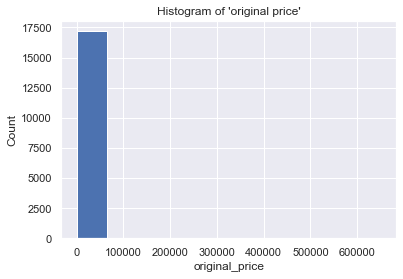

In [28]:
plt.hist(games['original_price'])
plt.title("Histogram of 'original price'")
plt.ylabel('Count')
plt.xlabel('original_price')

There's atleast one value of around $700,000 which seems absurd for a video game.

In [29]:
# Find games over 50000
games[games['original_price'] > 50000]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
17122,Slime-san: Superslime Edition,"Apr 7, 2017",Fabraz,85.0,650560.0,0.92,27.0,True,False


The prices for 'Slime-san: Superslime Edition' and 'Railgunners' would appear to represent a currency other than dollars, perhaps tokens or a virtual currency not included in the datasat. Without more information we can be comfortable dropping these two extreme values.

In [30]:
# Drop games with 'original price' over 50000
games = games.drop(games[games['original_price'] > 50000].index)

Text(0.5, 0, 'original_price')

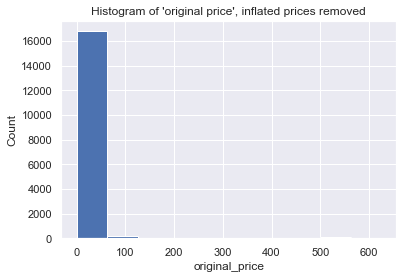

In [31]:
ax = plt.hist(games['original_price'])
plt.title("Histogram of 'original price', inflated prices removed")
plt.ylabel('Count')
plt.xlabel('original_price')

$600 for a game still seems absurd. Let's have a look

In [32]:
# Find games with 'original price' over 300
games[games['original_price'] > 300]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
974,VEGAS Pro 16 Edit Steam Edition,"Sep 3, 2018",MAGIX Software GmbH,0.0,399.00,0.55,18.0,True,False
1314,VEGAS Pro 14 Edit Steam Edition,"Sep 30, 2016",MAGIX Software GmbH,0.0,598.00,0.77,385.0,True,False
2634,Choice of Robots,"Dec 19, 2014",Choice of Games,72.0,501.87,0.97,1669.0,False,False
2925,Choice of the Pirate,"May 20, 2016",Choice of Games,18.0,501.87,0.91,83.0,False,False
2931,A Wise Use of Time,"Sep 4, 2015",Choice of Games,38.0,501.87,0.81,105.0,False,False
...,...,...,...,...,...,...,...,...,...
26754,Phantom Soldier,"Mar 29, 2017",Virtual Top,500.0,624.74,0.39,314.0,False,False
32302,Congresswolf,"Oct 28, 2016",Choice of Games,38.0,501.87,0.58,12.0,False,False
33811,Neighbourhood Necromancer,"May 16, 2014",Choice of Games,24.0,501.87,0.63,11.0,False,False
35309,Choice of the Ninja,"Nov 17, 2017",Choice of Games,0.0,501.87,0.63,11.0,False,False


Text(0.5, 1.0, 'Developers with games over $300')

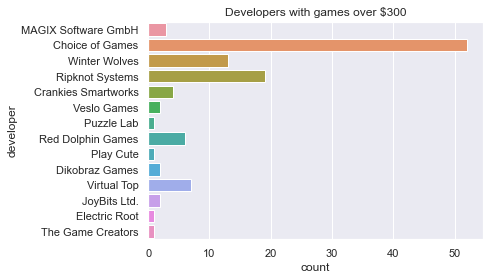

In [33]:
# Count the developers with games over 300
ax = sns.countplot(data=games[games['original_price'] > 300], y='developer')
ax.set_title("Developers with games over $300")

There seems to be an issue with some developers having prices that are extremely high, possibly from bundles. For a small amount of outliers we can be comfortable with dropping these rows.

In [34]:
# Drop games with 'original price' over 300
games = games.drop(games[games['original_price'] > 300].index)

Plotting an ECDF allows us to see if there's any relationship between the price of a game and wither or not it has multiplayer and wither or not it rated Mature.

Text(0.5, 0, 'original_price ($)')

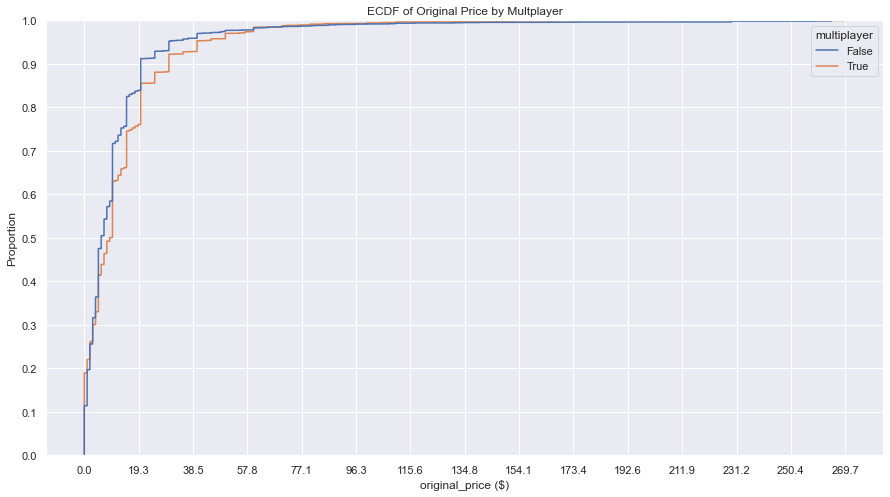

In [35]:
# Import numpy
import numpy as np

# Set figure size
plt.figure(figsize = (15,8))

# Plot ecdf
ax = sns.ecdfplot(data=games, x="original_price", hue="multiplayer")

# Set ticks and title
ax.set_yticks([0,0.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_xticks(np.linspace(min(games['original_price']),max(games['original_price']),15))
ax.set_title('ECDF of Original Price by Multplayer')
ax.set_xlabel('original_price ($)')

Text(0.5, 0, 'original_price ($)')

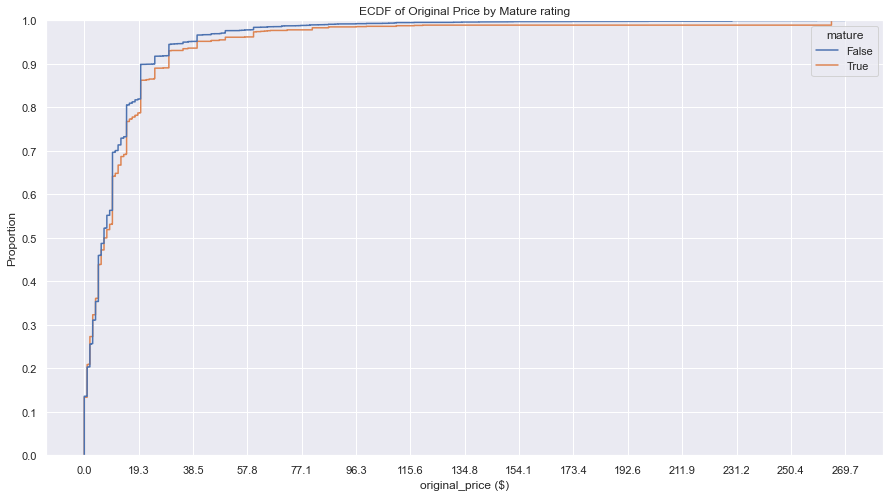

In [36]:
# Set figure size
plt.figure(figsize = (15,8))

# Plot ecdf
ax = sns.ecdfplot(data=games, x="original_price", hue="mature")

# Set ticks and title
ax.set_yticks(np.linspace(0,1,11))
ax.set_xticks(np.linspace(min(games['original_price']),max(games['original_price']),15))
ax.set_title('ECDF of Original Price by Mature rating')
ax.set_xlabel('original_price ($)')

There is evidence that having multiplayer in a game increases the original cost of a game.
Wither a game is rated mature or a small impact on the price.

An ECDF of 'original_price' alone would also show trends in price.

Text(0.5, 0, 'original_price ($)')

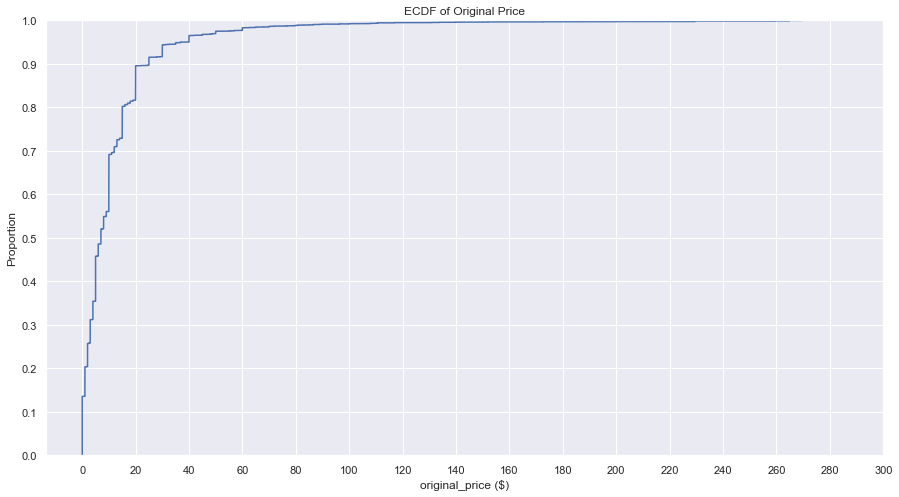

In [37]:
# Set figure size
plt.figure(figsize = (15,8))

# Plot ecdf
ax = sns.ecdfplot(data=games, x="original_price")

# Set ticks and title
ax.set_yticks(np.linspace(0,1,11))
ax.set_xticks(np.linspace(0,300,16))
#ax.set_xticks(np.linspace(min(games['original_price']),max(games['original_price']),20))
ax.set_title('ECDF of Original Price')
ax.set_xlabel('original_price ($)')

As percent_positive is dependent on num_reviews, numpy can be used to investigate any colleration using Pearson correlation coefficients.

In [38]:
# Print correlation coefficient of number of reviews and percentage of positive reviews
print(np.corrcoef(games['num_reviews'],games['percent_positive']))

[[1.         0.04214276]
 [0.04214276 1.        ]]


A value near 0 indicates a lack of colleration between the two variables, meaning one doesn't affect the other.

Text(0.5, 0, 'percent_positive (%)')

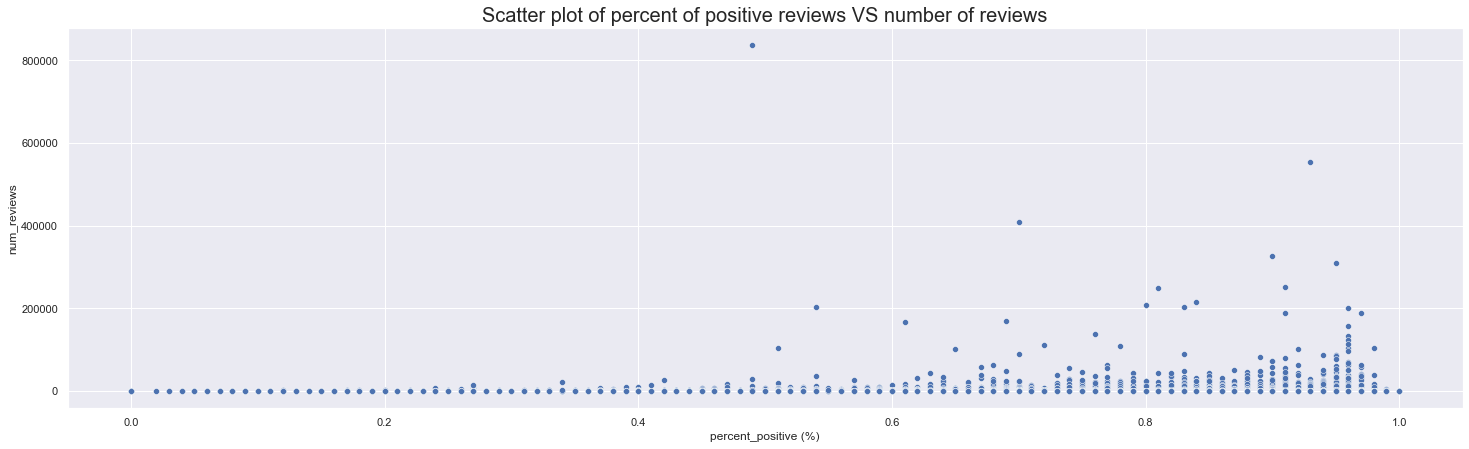

In [39]:
# Set figure size
plt.figure(figsize = (25,7))

# Plot scatterplot and set title
ax = sns.scatterplot(
    data=games, y="num_reviews", x="percent_positive"
)
ax.set_title('Scatter plot of percent of positive reviews VS number of reviews', fontsize = 20)
ax.set_xlabel('percent_positive (%)')

In [40]:
# Find games with a high number of reviews
games[games['num_reviews'] > 250000]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,29.99,0.49,836608.0,True,True
305,Garry's Mod,"Nov 29, 2006",Facepunch Studios,29.0,9.99,0.95,310394.0,True,False
354,Team Fortress 2,"Oct 10, 2007",Valve,520.0,0.00,0.93,553458.0,True,True
375,Grand Theft Auto V,"Apr 14, 2015",Rockstar North,77.0,29.99,0.70,407706.0,True,True
376,Warframe,"Mar 25, 2013",Digital Extremes,187.0,19.99,0.91,250319.0,True,True
611,Unturned,"Jul 7, 2017",Smartly Dressed Games,46.0,0.00,0.90,325675.0,True,False


The scatterplot shows a braod range of values with some grouping towards the more positively reviewed games. This would fit with more people wanting to play favourably reviewed games.
The outliers are games that extremely well known and have recieved a massive number of reviews in comparison to others so those will be kept in the dataset.

Text(0.5, 1.0, 'Violin plot of number of reviews for a game based on multiplayer')

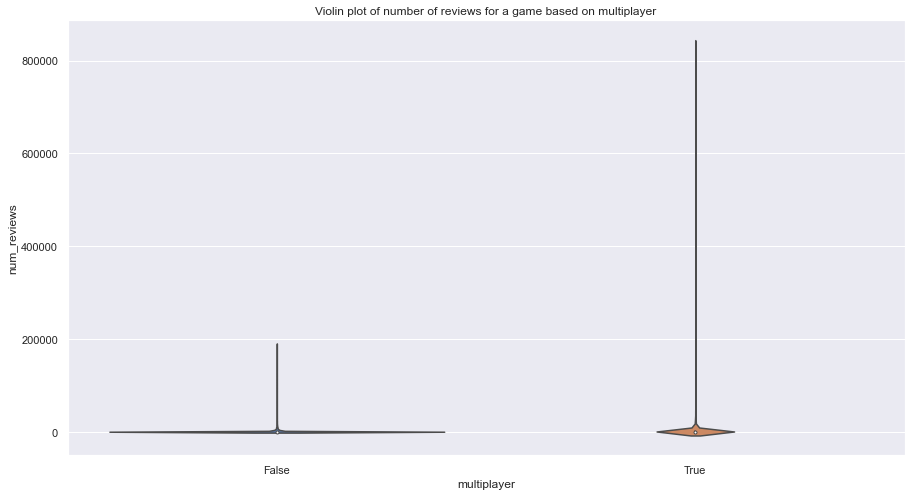

In [41]:
# Set figure size
plt.figure(figsize = (15,8))

# Plot violin plot and title
ax = sns.violinplot(x="multiplayer", y="num_reviews", data=games)
ax.set_title('Violin plot of number of reviews for a game based on multiplayer')

There is still a high number of small reviews which makes using the number of reviews as a matric for a model less viable.

Text(0.5, 1.0, 'Violin plot of percentage of positive reviews for a game based on multiplayer')

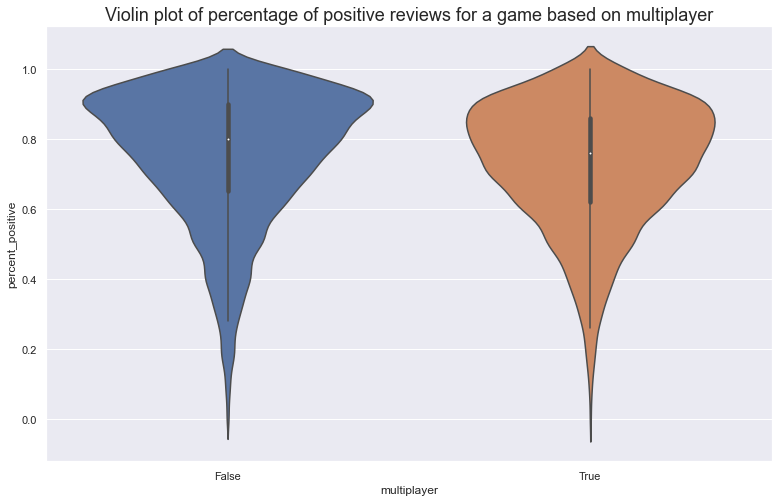

In [42]:
# Set figure size
plt.figure(figsize = (13,8))

# Plot violin plot and title
ax = sns.violinplot(x="multiplayer", y="percent_positive", data=games)
ax.set_title('Violin plot of percentage of positive reviews for a game based on multiplayer', fontsize = 18)

Text(0.5, 1.0, 'Violin plot of percentage of positive reviews for a game based on maturity rating')

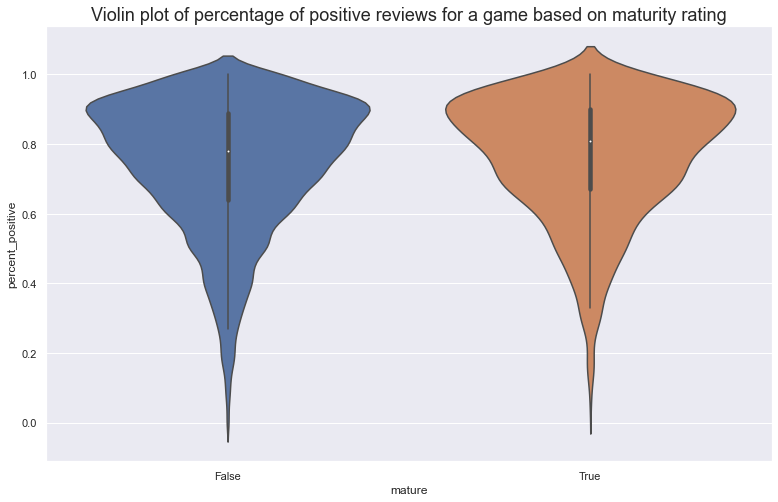

In [43]:
# Set figure size
plt.figure(figsize = (13,8))

# Plot violin plot and title
ax = sns.violinplot(x="mature", y="percent_positive", data=games)
ax.set_title('Violin plot of percentage of positive reviews for a game based on maturity rating', fontsize = 18)

Games that don't have multiplayer have a slightly more consistent favourable ratings compared to those that do have multiplayer.

The maturtiy rating of a game has no impact on how favourably it is rated.

### Building a model

With unlabelled data that we wish to cluster, K-Means will be the machine learning algorithm to be used.
First thing will be to scale the data using the Sci-kit learn standard scaler, which is applied to columns and not rows.

In [44]:
# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Create a scaler
scaler = StandardScaler()

# Decide on the columns we're going to try and use
games_columns = ['achievements','original_price','percent_positive','multiplayer','mature']

# Scale the data
games_scaled = scaler.fit_transform(games[games_columns])

# Dataframe to apply cluster numbers to later
games_scaled_df = pd.DataFrame(games_scaled, columns=games_columns)

With the scaled data we can use K-means and create an elbow plot to show the inertia of different values of k.

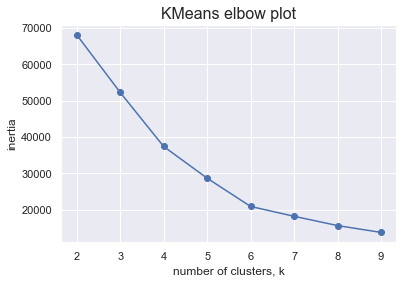

In [45]:
from sklearn.cluster import KMeans

ks = range(2, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model (random state 13 for replication)
    model = KMeans(n_clusters=k, random_state=13)
    
    # Fit model to data
    model.fit(games_scaled)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.title('KMeans elbow plot', fontsize=16)
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The from the elbow graph results the best K for KMeans is 6 clusters.

With the optimial value for K being 6, the clusters can be predicted for each value and applied to the dataframe row.

In [46]:
# Initialise KMeans model object with n_clusters as 6 (random state 13 for replication)
kmeans = KMeans(n_clusters=6, random_state=13)

# Fit model to scaled data
kmeans.fit(games_scaled)

# Predict the clusters for each value
clusters = kmeans.predict(games_scaled)

# Apply cluster value to scaled dataframe
games_scaled_df['cluster'] = clusters

games_scaled_df.head()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0e67cf5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


,achievements,original_price,percent_positive,multiplayer,mature,cluster
0,0.051855,0.433366,0.930439,1.57526,-0.307626,2
1,-0.004895,0.950163,-1.382995,1.57526,3.250703,3
2,0.298885,1.466959,-0.199378,1.57526,-0.307626,2
3,-0.128410,1.725358,-0.737385,1.57526,-0.307626,2
4,-0.128410,-0.599711,-0.037975,1.57526,-0.307626,2


Summing all the values in each feature will show which features are more prevelant in each cluster. This is done using groupby on the cluster value.

In [47]:
# Sum values of different columns per cluster using groupby
clustered_game_values = games_scaled_df.groupby(by='cluster', as_index=False).sum()
clustered_game_values

,cluster,achievements,original_price,percent_positive,multiplayer,mature
0,0,-226.647977,-536.035243,-4265.193562,-1728.559123,-949.025345
1,1,-396.428313,-801.555753,4354.470457,-4985.209141,-2415.784776
2,2,-251.805475,72.414504,-181.627184,6978.401310,-1362.781938
3,3,-105.330026,-32.645084,141.378194,-202.843222,4716.770762
4,4,991.026554,-4.271808,-22.089854,-35.267621,-9.628310
5,5,-10.814763,1302.093384,-26.938050,-26.522204,20.449607


The summed values for each cluster can be plotted on a line graph and it can be seen which features, if any, are most prevalent.

A higher prevelance of a feature would be an strong indidication of a suitable category.

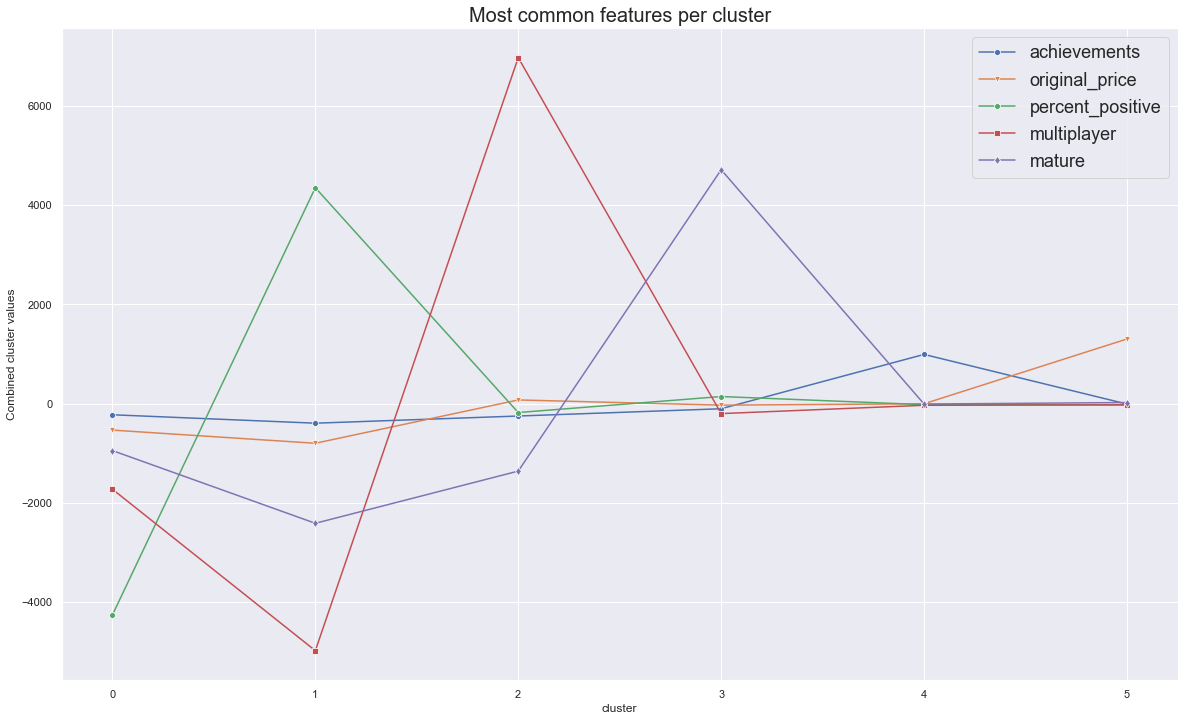

In [52]:
# Set the plot size
plt.figure(figsize = (20,12))

# Plot each column values as a lineplot
ax = sns.lineplot(y='achievements', x='cluster', data=clustered_game_values, marker="o", markers=True)
ax = sns.lineplot(y='original_price', x='cluster', data=clustered_game_values, marker="v", markers=True)
ax = sns.lineplot(y='percent_positive', x='cluster', data=clustered_game_values, marker="8", markers=True)
ax = sns.lineplot(y='multiplayer', x='cluster', data=clustered_game_values, marker="s", markers=True)
ax = sns.lineplot(y='mature', x='cluster', data=clustered_game_values, marker="d", markers=True)

# Set ticks, title, labels and legend
ax.set_title('Most common features per cluster', fontsize = 20)
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylabel('Combined cluster values')
ax.legend(games_columns, fontsize = 18)

The best categories for cluster would show strongly positive categories values for that cluster.

From the figure above, cluster 1 shows that "percent_positive" is a strong feature, cluster 2 shows "multiplayer" is a strong feature and cluster 3 shows "mature" rating is a strong feature.

"achievements" and "original_price" did not feature more or less significantly in any cluster.

Three additional categories for the website would be if a game has multiplayer, if a game is rated mature and if a game has a high percentage of positive reviews.

### Conclusion and Recommendations

Three new categories for the Snow Cone Games wesbite are recommended. These are 'Multiplayer', 'Mature' and 'Highly Rated'.

These recommendations are made from results of the most prevelant features as discovered in KMeans clusters.

A better model to make category recommendations could be produced in the future if tighter controls on the data entry for "release_date" and "original_price" were put in place.